In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import importlib

In [2]:
from kaggle_submit import submit_to_kaggle
from helpers import *
from utils.globals import *
from utils.distribution_statistics import *

train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

# MAKE CUSTOM FEATURES
from additional_features.make_features import make_all_features
make_all_features(h5_train, h5_test, n_chunks=10, verbose=True, overwrite=False)


from objects import *

In [3]:
def ensure_integrity(h5_file):
    keys = list(h5_file.keys())
    for i, key in enumerate(keys):
        print_bis(f'{i+1}/{len(keys)}')
        x = h5_file[key][:]
        assert np.sum(np.isnan(x)) == 0
        assert np.sum(np.isinf(x)) == 0
        
# ensure_integrity(h5_train)
# ensure_integrity(h5_test)

In [4]:
"""
# SAVE MODEL

from joblib import dump, load
ARCHIVES_FOLDER = "models_archives"
if not os.path.exists(ARCHIVES_FOLDER):
    os.makedirs(ARCHIVES_FOLDER)

def save_model(model, name):
    fpath = os.path.join(ARCHIVES_FOLDER, f"{name}.joblib")
    dump(model, fpath)
    print(f"New model saved at {fpath}")
    return fpath
    
    
def load_model(name):
    if not name.startswith(ARCHIVES_FOLDER):
        name = os.path.join(ARCHIVES_FOLDER, name)
    if not name.endswith(".joblib"):
        name = f"{name}.joblib"
    model = load(name)
    return model

LEADERBOARD_FILE = "leaderboard.txt"
if not os.path.exists(LEADERBOARD_FILE):
    with open(LEADERBOARD_FILE, 'a') as leaderboard:
        leaderboard.write(";;;".join(['path', 'training_score', 'validation_score', 'comments']))
    
def write_model_to_leaderboard(model, model_name, train_score, val_score, comments=""):
    fpath = save_model(model, model_name)
    with open(LEADERBOARD_FILE, "a") as leaderboard:
        leaderboard.write("\n" + ';;;'.join([fpath, str(train_score), str(val_score), comments]))
    
"""
_ = ""
# np.min(h5_train[BAND_LOG_ENERGY_FEATURES[0]][:])

In [11]:
features_df = pd.DataFrame(list(set(h5_train.keys()) - set(IRRELEVANT_FEATURES)), columns=["Feature"])
features_df.loc[:, "Dim"] = features_df['Feature'].apply(lambda x: h5_train[x][0].shape[0])
features_df.sort_values(by=["Dim", "Feature"])

import re

BAND_LOG_ENERGY_FEATURES = [feat for feat in FEATURES if re.search("(?:(?:alpha)|(?:beta)|(?:delta)|(?:theta)){1}.*_logE", feat)]

SLEEP_FEATURES = [feat for feat in FEATURES if re.search('sleep.*[^(?:logmod)]', feat)]

LOGMOD_FEATURES = [feat for feat in FEATURES if re.search('.*_logmod', feat)]

TIME_FEATURES

OTHER_FEATURES = ["pulse_max_freq", "pulse_max_logE"]

_features = sum([BAND_LOG_ENERGY_FEATURES, SLEEP_FEATURES, LOGMOD_FEATURES, TIME_FEATURES, OTHER_FEATURES], [])
assert sorted(_features) == sorted(FEATURES)

## Input maker
    
def make_input_default(h5_file):
    df_bandlog = make_input_bis(
        h5_file,
        features=BAND_LOG_ENERGY_FEATURES,
        rescale=True,
        moments=[1, 2],
        pre_op=np.exp,
        pre_op_name="energy"
    )
    
    df_sleep = make_input_bis(
        h5_file,
        features=SLEEP_FEATURES,
        rescale=False,
        moments=[1]
    )
    
    ## LOGMOD RENAME COLUMNS
    
    df_logmod_no_rescale = make_input_bis(
        h5_file,
        features=LOGMOD_FEATURES,
        rescale=False,
        moments=[1, 2],
        quantiles=[0.05, 0.95],
        quantiles_inv=[0.1, 0.3, 0.5, 0.7, 0.9],
        diff_orders=[0, 1],
        pre_op=lambda x: np.exp(2 * x),
        pre_op_name="energy"
    )
    
    cols_no_rescale = [(col[0] + "_no_rescale", *col[1:]) for col in df_logmod_no_rescale.columns]
    df_logmod_no_rescale.columns = pd.MultiIndex.from_tuples(cols_no_rescale)
    
    df_logmod_with_rescale = make_input_bis(
        h5_file,
        features=LOGMOD_FEATURES,
        rescale=True,
        moments=[1, 2],
        quantiles=[0.05, 0.95],
        quantiles_inv=[0.1, 0.3, 0.5, 0.7, 0.9],
        diff_orders=[0, 1],
        pre_op=lambda x: np.exp(2 * x),
        pre_op_name="energy"
    )
    
    cols_with_rescale = [(col[0] + "_with_rescale", *col[1:]) for col in df_logmod_with_rescale.columns]
    df_logmod_with_rescale.columns = pd.MultiIndex.from_tuples(cols_with_rescale)
    
    ## END LOGMOD
    
    
    df_time = make_input_bis(
        h5_file,
        features=TIME_FEATURES,
        rescale=False,
        moments=[1, 2, 3, 4],
        quantiles=[0.01, 0.05, 0.95, 0.99]
    )
    
    df_pulse_max_freq = make_input_bis(
        h5_file,
        features=["pulse_max_freq"],
        rescale=False,
        moments=[1],
    )
    
    df_pulse_max_logE = make_input_bis(
        h5_file,
        features=["pulse_max_logE"],
        rescale=False,
        moments=[1, 2],
        pre_op=np.exp,
        pre_op_name="energy"
    )
    
    return pd.concat([df_bandlog, df_sleep, df_logmod_no_rescale, df_logmod_with_rescale, df_time, df_pulse_max_freq, df_pulse_max_logE], axis=1)

default_im = InputMaker(make_input_default)

In [12]:
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

default_im = InputMaker(make_input_default)
default_is = InputShaper(StandardScaler())
default_is_with_pre_pca = InputShaper(PCA(0.95), StandardScaler())
default_is_with_post_pca = InputShaper(MinMaxScaler(), PCA(0.95))

In [13]:
# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

#groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
#custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
#glouton_is = InputShaper(*custom_pcas, StandardScaler())

svm_grid_1 = ParameterGrid({"kernel": ["rbf", "sigmoid"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "gamma": ["auto", "scale"]}
                          )
#svm_grid_2 = ParameterGrid({"kernel": ["poly"],
 #                           "C": [0.01, 0.1, 1, 10, 100],
  #                          "degree": [1, 2, 3, 4]}
   #                       )

svm_hyperparameters = list(svm_grid_1)

from sklearn.svm import SVC

svc_pool = PoolModels(
    input_maker=default_im,
    n_splits=3,
    train_size=27,
    input_shaper=default_is,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter": 50},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

svc_pool.make_train_input()

In [14]:
svc_pool.warm_up()

Split #1/3 - WARM UP Model #1/20 [ETA: ?]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #2/20 [ETA: 144.34s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #3/20 [ETA: 132.88s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #4/20 [ETA: 129.16s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #5/20 [ETA: 121.11s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #6/20 [ETA: 113.63s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #7/20 [ETA: 105.68s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #8/20 [ETA: 98.44s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #9/20 [ETA: 91.42s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #10/20 [ETA: 84.44s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #11/20 [ETA: 76.65s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #12/20 [ETA: 69.03s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #13/20 [ETA: 61.27s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #14/20 [ETA: 53.98s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #15/20 [ETA: 46.35s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #16/20 [ETA: 38.88s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #17/20 [ETA: 31.07s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #18/20 [ETA: 23.3s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #19/20 [ETA: 15.47s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #1/3 - WARM UP Model #20/20 [ETA: 7.76s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #1/20 [ETA: ?]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #2/20 [ETA: 155.74s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #3/20 [ETA: 141.53s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #4/20 [ETA: 132.7s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #5/20 [ETA: 123.9s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #6/20 [ETA: 115.77s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #7/20 [ETA: 107.43s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #8/20 [ETA: 100.46s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #9/20 [ETA: 93.3s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #10/20 [ETA: 85.6s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #11/20 [ETA: 77.39s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #12/20 [ETA: 69.66s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #13/20 [ETA: 61.81s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #14/20 [ETA: 54.13s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #15/20 [ETA: 46.23s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #16/20 [ETA: 38.9s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #17/20 [ETA: 31.27s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #18/20 [ETA: 23.44s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #19/20 [ETA: 15.61s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #2/3 - WARM UP Model #20/20 [ETA: 7.84s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #1/20 [ETA: ?]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #2/20 [ETA: 145.31s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #3/20 [ETA: 138.96s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #4/20 [ETA: 135.21s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #5/20 [ETA: 125.77s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #6/20 [ETA: 116.97s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #7/20 [ETA: 108.54s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #8/20 [ETA: 100.96s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #9/20 [ETA: 94.08s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #10/20 [ETA: 86.15s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #11/20 [ETA: 77.88s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #12/20 [ETA: 69.95s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #13/20 [ETA: 62.08s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #14/20 [ETA: 54.52s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #15/20 [ETA: 46.54s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #16/20 [ETA: 39.05s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #17/20 [ETA: 31.13s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #18/20 [ETA: 23.49s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #19/20 [ETA: 15.6s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Split #3/3 - WARM UP Model #20/20 [ETA: 7.8s]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


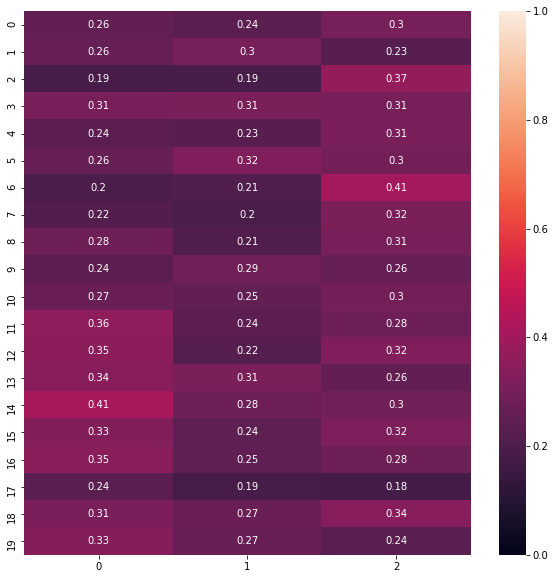

In [15]:
svc_pool.plot_validation()

In [ ]:

# Hyperparameters grid
from sklearn.model_selection import ParameterGrid


random_forest_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [100, 1000]
}

rf_hyperparameters = list(ParameterGrid(random_forest_params))
rf_hyperparameters_low_cost = list(ParameterGrid(random_forest_params_low_cost))

from sklearn.ensemble import RandomForestClassifier

rf_glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=3,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=RandomForestClassifier,
    parameters_list=rf_hyperparameters,
    warming_params={},
    convergence_params={},
    seed=10,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)



In [ ]:
rf_glouton_pool.make_train_input()
rf_glouton_pool.warm_up()
rf_glouton_pool.plot_validation()

In [16]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_hyperparameters = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [10, 20, 30],
    "min_samples_split": [100, 500, 1000],    
}

decision_tree_hyperparameters = list(ParameterGrid(decision_tree_hyperparameters))

dt_glouton_pool = PoolModels(
    input_maker=default_im,
    n_splits=3,
    train_size=27,
    input_shaper=default_is,
    blueprint=DecisionTreeClassifier,
    parameters_list=decision_tree_hyperparameters,
    warming_params={},
    convergence_params={},
    seed=10,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)


In [17]:
dt_glouton_pool.make_train_input()
dt_glouton_pool.warm_up()
dt_glouton_pool.plot_validation()

Split #1/3 - WARM UP Model #1/36 [ETA: ?]
Split #1/3 - WARM UP Model #2/36 [ETA: 185.88s]
Split #1/3 - WARM UP Model #3/36 [ETA: 96.86s]
Split #1/3 - WARM UP Model #4/36 [ETA: 113.66s]
Split #1/3 - WARM UP Model #5/36 [ETA: 85.29s]
Split #1/3 - WARM UP Model #6/36 [ETA: 93.49s]
Split #1/3 - WARM UP Model #7/36 [ETA: 76.66s]
Split #1/3 - WARM UP Model #8/36 [ETA: 97.96s]
Split #1/3 - WARM UP Model #9/36 [ETA: 85.18s]


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost_hyperparameters = {
    "n_estimators": [2, 8, 16, 32],
    "learning_rate": [1, 0.7, 0.3, 0.1],
}

ada_boost_hyperparameters = list(ParameterGrid(ada_boost_hyperparameters))

ada_boost_glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=3,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=AdaBoostClassifier,
    parameters_list=np.random.permutation(ada_boost_hyperparameters),
    warming_params={},
    convergence_params={},
    seed=10,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

ada_boost_glouton_pool.make_train_input()
ada_boost_glouton_pool.warm_up()
ada_boost_glouton_pool.plot_validation()

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_hyperparameters_space = {
    "reg_param": [0, 0.5, 0.7]
}

qda_hyperparameters_space = list(ParameterGrid(qda_hyperparameters_space))

default_im = InputMaker(make_input_default)

default_is = InputShaper(StandardScaler())

qda_pool = PoolModels(
    input_maker=default_im,
    n_splits=10,
    train_size=27,
    input_shaper=InputShaper(PCA(0.95), StandardScaler()),
    blueprint=QuadraticDiscriminantAnalysis,
    parameters_list=qda_hyperparameters_space,
    warming_params={},
    convergence_params={},
    seed=10,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr,
)

qda_pool.warm_up()
qda_pool.plot_validation()

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_hyperparameters = {"var_smoothing": [1e-9, 1e-6]}
nb_hyperparameters = list(ParameterGrid(nb_hyperparameters))

nb_pool = PoolModels(
    input_maker=default_im,
    n_splits=3,
    train_size=27,
    input_shaper=InputShaper(StandardScaler()),
    blueprint=GaussianNB,
    parameters_list=nb_hyperparameters,
    warming_params={},
    convergence_params={},
    seed=10,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr,
)

nb_pool.warm_up()
nb_pool.plot_validation()

In [ ]:
sleep_stages = y_train_arr

def mean_stat(feat):
    mean_samples = np.mean(h5_train[feat][:], axis=1)
    df = pd.DataFrame(mean_samples, columns=[feat], index=y_train_arr)
    return df.groupby(df.index).agg([np.mean, np.std])

def quantile_stat(feat, func_arr=lambda x: np.mean(x, axis=1), quantiles=np.linspace(0.1, 0.9, 9).round(2)):
    samples_stat = func_arr(h5_train[feat][:])
    df = pd.DataFrame(samples_stat, columns=[feat], index=y_train_arr)
    quantiles_df = df.groupby(df.index).apply(lambda x: np.quantile(x, q=quantiles))
    quantiles_df = np.array(quantiles_df.tolist())
    quantiles_df = pd.DataFrame(quantiles_df, columns=[str(q) for q in quantiles])
    return quantiles_df

def plot_quantile_stat(features, func_arr, func_name, quantiles, logscale=False):
    for feat in features:
        qstat = quantile_stat(feat, func_arr, quantiles=quantiles)
        # print(qstat)
        for i in range(len(qstat.columns)):
            plt.scatter(qstat.index, qstat.values[:, i])
        plt.title(feat + f" quantiles of {func_name}")
        if logscale:
            plt.yscale("log")
        plt.show()

def create_quantile_plot():
    pass
        


# z = quantile_stat("eeg_1")

In [ ]:
def moment(arr, order, diff_order):
    return np.mean(differentiate(arr, diff_order) ** order, axis=1)

# f = lambda x: moment(x, order=4, diff_order=0)
# f = lambda x: np.quantile(x, q=0.9, axis=1) - np.quantile(x, q=0.1, axis=1)
f = lambda x: np.quantile(x, q=0.95, axis=1)
plot_quantile_stat(TIME_FEATURES, f, "", quantiles=[0.3, 0.5, 0.7], logscale=True)

In [ ]:
np.quantile(np.arange(100), q=0.9) - np.quantile(np.arange(100), q=0.1)

In [ ]:
make_input_bis(h5_train, features=["delta_eeg_3_logE"], moments=[1, 2], diff_orders=[0], quantiles=[], rescale=False)

In [ ]:
get_distribution_characteristics(differentiate(h5_train["delta_eeg_3_logE"][0:3], order=0), moments=[1, 2])

In [ ]:
differentiate(do_not)

In [ ]:
def get_distribution_quantiles_inv(arr, quantiles, **kwargs):
    cdf = np.cumsum(arr, axis=1, **kwargs) 
    cdf /= cdf[:, [-1]]
    res = np.empty(shape=(arr.shape[0], len(quantiles)))
    for i, q in enumerate(quantiles):
        res[:, i] = np.argmax(q <= cdf, axis=1)
    return res

get_distribution_quantiles_inv(np.random.rand(100, 10), [0.1, 0.9])

In [ ]:
np.random.rand(100, 10).shape